# Uudiste klasterdamine (KMeans, hierarhiline klasterdamine)

In [65]:
import pandas as pd

In [66]:
data_delfi = pd.read_csv("data_delfi_arhiiv_03122020.csv").dropna()
data_telegram_rubriigid = pd.read_csv("data_telegram_rubriigid_arhiiv.csv").dropna()
data_uueduudised_rubriigid = pd.read_csv("data_uueduudised_rubriigid_arhiiv.csv").dropna()

In [67]:
data_delfi.shape

(6152, 4)

In [68]:
data_telegram_rubriigid.shape

(6264, 5)

In [69]:
data_uueduudised_rubriigid.shape

(6999, 5)

In [70]:
data = pd.concat([data_delfi, data_telegram_rubriigid, data_uueduudised_rubriigid])

In [71]:
data.shape

(19415, 5)

In [73]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [75]:
#data

In [76]:
data.to_csv('data_rubriigid.csv', index = False)

In [41]:
from estnltk import Text

# Meetod teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

def lemmatize_with_estnltk(input_string):
    lemma = Text(input_string).tag_layer(['morph_analysis']).lemma
    # https://stackoverflow.com/questions/11264684/flatten-list-of-lists/11264799
    flattened  = [val for sublist in lemma for val in sublist]
    return flattened

stopsõnad_fn = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui',
             '!','"','(',')','+',',','-','--','.','...','/','?', ':', ';', '_', '’','“','”']
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui',
             '!','"','(',')','+',',','-','--','.','...','/','?', ':', ';', '_', '’','“','”',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', 'setu']

In [77]:
data200 = data[:5000]

In [78]:
data200.shape

(5000, 5)

# Klasterdamise osa on adapteeritud järgmisest koodist
http://brandonrose.org/clustering https://seangtkelley.me/blog/2018/01/03/news-article-clustering

# KMeans klasterdamine

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stopsõnad_fn,
                                 use_idf=True, tokenizer = lemmatize_with_estnltk, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(data200['text']) #fit the vectorizer to synopses

In [45]:
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(5000, 129)


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [47]:
from sklearn.cluster import KMeans
import math

#num_clusters = int(math.sqrt(data.shape[0] / 2) * 1.5)
num_clusters = 3
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
clusters = km.labels_.tolist()

data200['cluster'] = clusters

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
import numpy as np
print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    #print("Cluster %d words:" % i, end='')
    #for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d subject:" % i, end='')
    print()
    for subject in data200[data200['cluster'] == i]['subject'].values.tolist():
        print(' - %s' % subject)
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:



Cluster 0 subject:
 - Telegram
 - Ilmateade
 - Uued Uudised
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Eesti Päevaleht
 - Delfi
 - Uued Uudised
 - Delfi
 - Ilmateade
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Maakodu
 - Delfi
 - Telegram
 - Forte
 - Telegram
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Eesti Päevaleht
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Te

 - Delfi
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Delfi
 - Eesti Päevaleht




Cluster 1 subject:
 - Delfi
 - Uued Uudised
 - Delfi
 - Delfi
 - Telegram
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Eesti Päevaleht
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Forte
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - 

 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Forte
 - Delfi
 - Uued Uudised
 - Ärileht
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Telegram
 - Eesti Päevaleht
 - Maaleht
 - Telegram
 - Delfi
 - Telegram
 - Eesti Päevaleht
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Eesti Päevaleht
 - Telegram
 - Telegram
 - Delfi


 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised






In [52]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}#, 3: '#e7298a', 4: '#66a61e', 5:'#123456'}

#set up cluster names using a dict
cluster_names = {0: 'Klaster 1', 
                 1: 'Klaster 2', 
                 2: 'Klaster 3', }
                 #3: 'Klaster 4', 
                 #4: 'Klaster 5',
                 #5: 'Klaster 6'
                #}

In [53]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

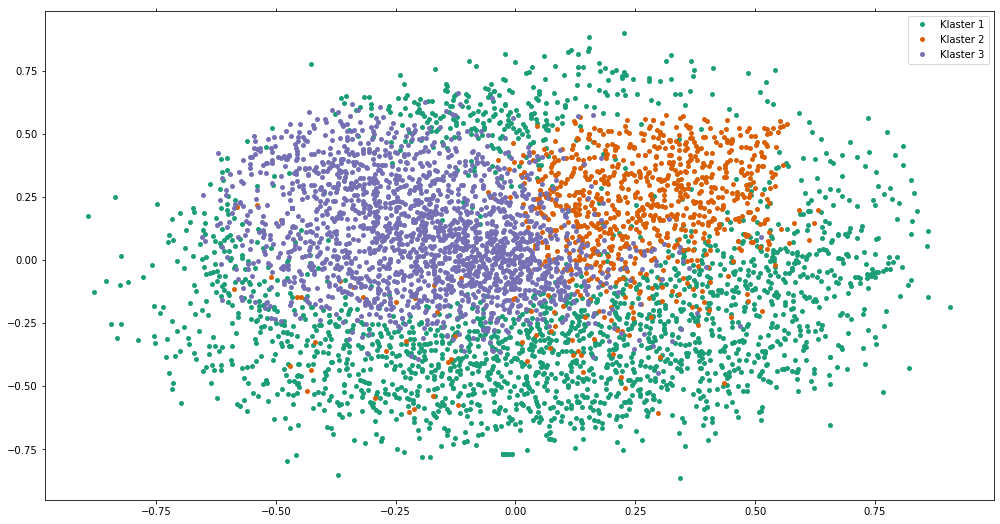

In [64]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, subject=data200.subject)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['subject'], size=8)  
    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# Hierarchical document clustering

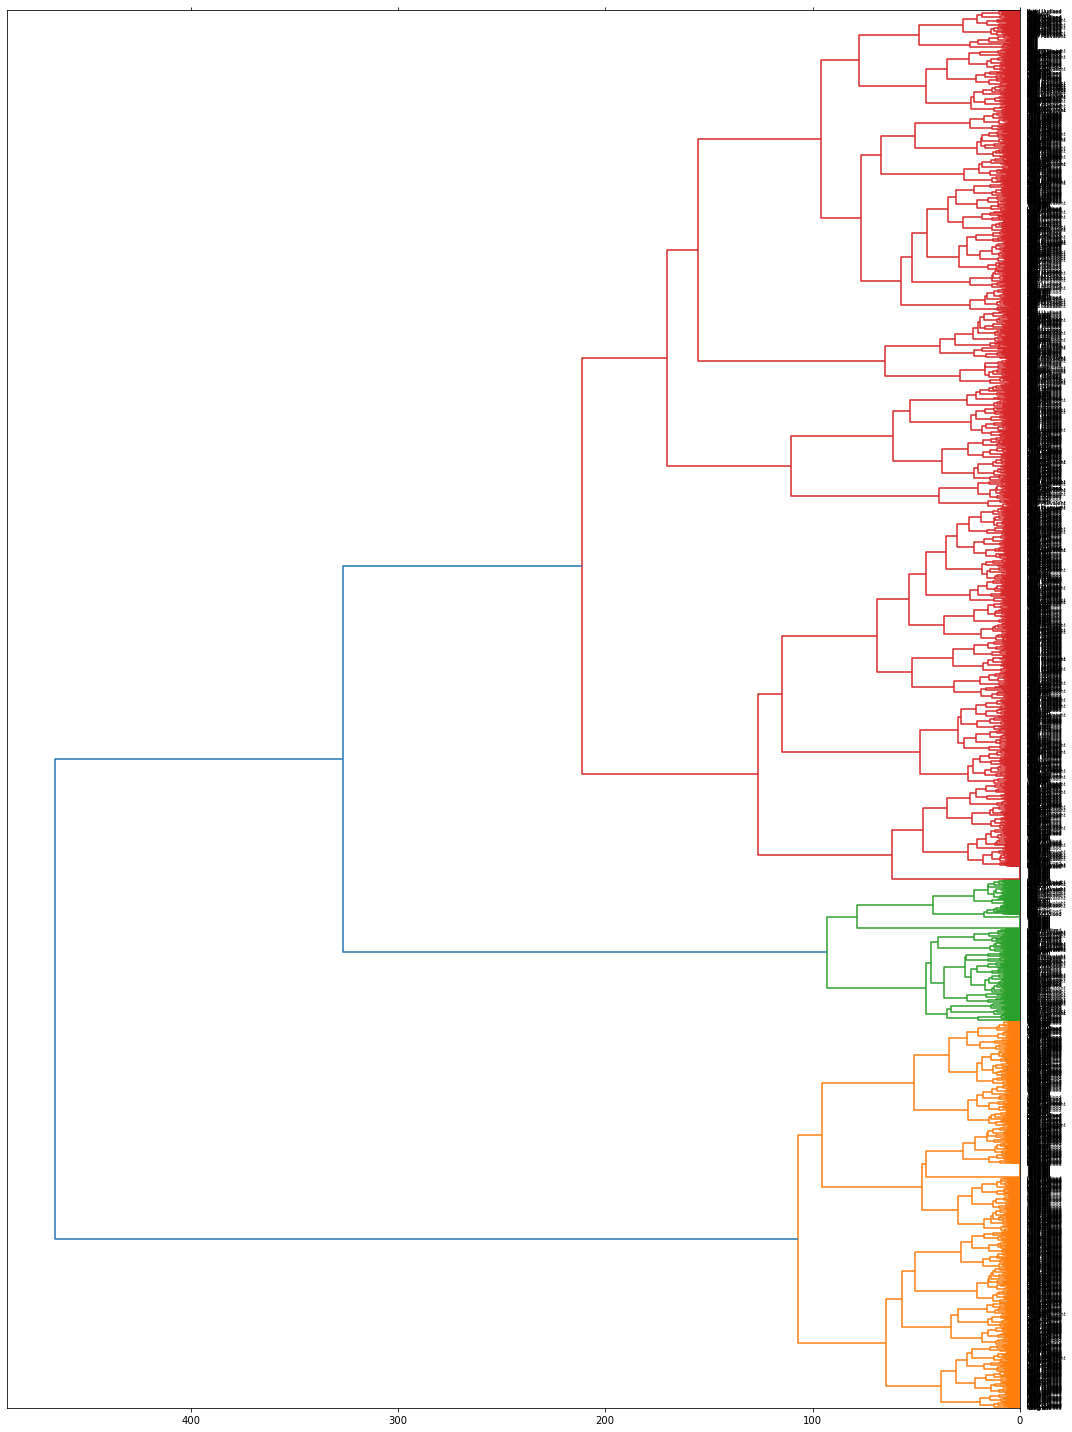

In [55]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=(list(data200.subject)))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters